# Notes


Computing the tracking parameter figures


# Imports

In [3]:
import numpy as np
import h5py
import time
import glob
import matplotlib.pyplot as plt
%matplotlib widget
%load_ext autoreload
import os
%autoreload 2
import sys

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare filepaths

In [4]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

In [5]:
# --- gather the filepaths needed to track the experiments --- #

main_dataset_folder = os.path.dirname(os.path.dirname(main_load_folder)) 
exp_folder_paths = glob.glob(main_dataset_folder+'/FishTank*')
exp_folder_paths.sort()  

# Panel A - cross-camera registration costs

In [6]:
# ------ load the cross-camera registration costs for frames solved using hungarian method -----#
exps_m1_reg_costs = []
for expIdx in range(len(expNames)):
    lp = loadpaths[expIdx]
    with h5py.File(lp, 'r') as hf:
        methodIdxs = hf['methodIdxs'][:]
        registration_costs = hf['registration_costs'][:]
    m1_reg_costs = registration_costs[methodIdxs==0]
    exps_m1_reg_costs.append(m1_reg_costs)

m1_reg_costs_master = np.concatenate(exps_m1_reg_costs)

m1_reg_costs_master.shape

(15643271, 2, 3)

In [7]:
# lets take every 100th to save time for now 
m1_reg_costs_master_downsampled = np.copy(m1_reg_costs_master[::100])

In [8]:
# ----- now convert to bodypoint means ---- #
t0 = time.perf_counter()


m1_reg_costs_meanBP = np.zeros((m1_reg_costs_master_downsampled.shape[0], m1_reg_costs_master_downsampled.shape[1]))*np.NaN
for ii in range(m1_reg_costs_master_downsampled.shape[0]):
    for fishIdx in range(2):
        bp_costs = m1_reg_costs_master_downsampled[ii, fishIdx]
        numBps_used = np.count_nonzero(~np.isnan(bp_costs))
        if numBps_used >= 2:
            m1_reg_costs_meanBP[ii,fishIdx] = np.nanmean(bp_costs)
m1_reg_costs_meanBP = m1_reg_costs_meanBP.reshape(-1)  # collapse along fish


tE = time.perf_counter()
print(tE-t0)

12.60652706772089


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
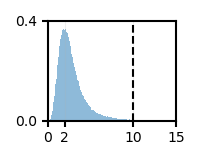

In [10]:

# the cost to histogram
reg_costs = np.copy(m1_reg_costs_meanBP)


# ---- the figure ---- #

fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs

histbins = np.linspace(0, 15, num=200)
ax.hist(reg_costs, label='head', alpha=0.5, density=True, bins=histbins)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

thresh=10
ax.axvline(x=thresh, color='black', linestyle='--')

ax.set_xlim(0, 12)
ax.set_ylim(0, 0.4)

ax.set_xticks([0,2,10,15])
ax.set_yticks([0, 0.4])

#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.set_xlabel('')
ax.set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
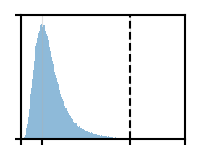

In [11]:
# the cost to histogram
reg_costs = np.copy(m1_reg_costs_meanBP)


# ---- the figure ---- #

fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs

histbins = np.linspace(0, 15, num=200)
ax.hist(reg_costs, label='head', alpha=0.5, density=True, bins=histbins)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

thresh=10
ax.axvline(x=thresh, color='black', linestyle='--')

ax.set_xlim(0, 12)
ax.set_ylim(0, 0.4)

ax.set_xticks([0,2,10,15])
ax.set_yticks([0, 0.4])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel('')
ax.set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.4)
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_A.png', dpi=300, transparent=True)

# Panel B - idtracker

In [12]:
t0 = time.time()

exps_absaccels = []

for expIdx in range(len(expNames)):
    #print(expIdx)
    
    raw_idtracker_filepath = os.path.join(exp_folder_paths[expIdx], 'idtracker_results/trajectories.npy')
    trajectories_dict = np.load(raw_idtracker_filepath, allow_pickle=True).item()
    idtraj = trajectories_dict['trajectories']
    
    # get the speeds etc of both fish
    speed = np.gradient(idtraj, axis=0)
    normspeed = np.linalg.norm(speed, axis=2)
    normaccel = np.gradient(normspeed, axis=0)
    absaccel = np.abs(normaccel)
    
    # collapse acceleration along fish
    absaccel_flat = absaccel.reshape((-1))
    
    # record
    exps_absaccels.append(absaccel_flat)
    
    
# combine experiments
exps_absaccels_master = np.concatenate(exps_absaccels)
    
tE = time.time()
print(tE-t0)

2.392932891845703


In [13]:
exps_absaccels_master.shape

(32088648,)

(0.0, 10.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
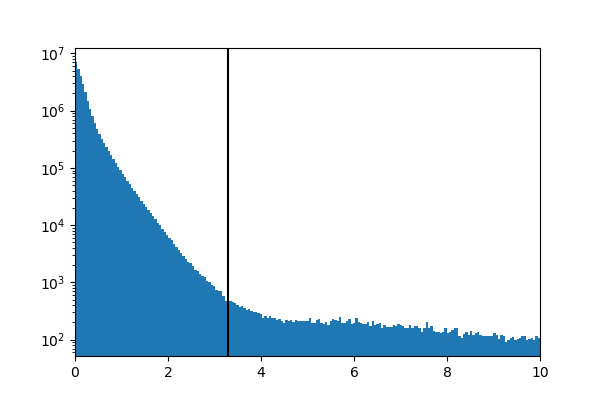

In [14]:
fig, axs = plt.subplots(figsize=(6,4))
ax = axs

ax.hist(exps_absaccels_master, 
        bins=np.linspace(0, 10, 200), 
        log=True,
        );

ax.axvline(x=3.3, color='black')

ax.set_xlim(0, 10)

#ax.set_yticks()



In [15]:
np.where(exps_absaccels_master >= 3.3)[0].shape

(31464,)

In [16]:
np.where(exps_absaccels_master <= 3.3)[0].shape

(28642149,)

/tmp/ipykernel_1984834/1834090485.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(2,1.6))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
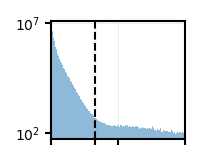

In [33]:
accel_thresh = 3.3


fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs
histbins = np.linspace(0, 10, num=200)

ax.hist(exps_absaccels_master, 
        bins=histbins, 
        alpha=0.5,
        log=True,
        );

ax.set_xlim(0,10)
ax.set_xticks([0,accel_thresh,5,10])

ax.set_yticks([10**2, 10**7])

ax.axvline(x=accel_thresh, color='black', linestyle='--')

ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_B1.png', dpi=300, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
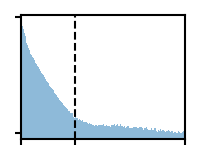

In [34]:
accel_thresh = 3.3


fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs
histbins = np.linspace(0, 10, num=200)

ax.hist(exps_absaccels_master, 
        bins=histbins, 
        log=True,
        alpha=0.5,
        );

ax.set_xlim(0,10)
ax.set_xticks([0,accel_thresh,10])

ax.axvline(x=accel_thresh, color='black', linestyle='--')


ax.set_yticks([10**2, 10**7])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(False)
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_B.png', dpi=300, transparent=True)

# Panel C - sleapPec to idTrackerCentroid

In [20]:
idtracker_to_sleap_costs = []

for expIdx in np.unique(fight_bout_info_noDurThresh[:,0]):
    path = loadpaths[expIdx]
    with h5py.File(path, 'r') as hf:
        idtracker_sleap_assignment_nothresh_costs = hf['idtracker_sleap_assignment_nothresh_costs'][:]
        idtracker_to_sleap_costs.append(idtracker_sleap_assignment_nothresh_costs)
        
        
# combine across experiments
idtracker_to_sleap_costs = np.concatenate(idtracker_to_sleap_costs, axis=0)

# flatten across fish
idtracker_to_sleap_costs = idtracker_to_sleap_costs.reshape(-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
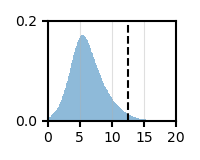

In [21]:
# the cost to histogram
reg_costs = np.copy(idtracker_to_sleap_costs)


# ---- the figure ---- #

fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs

histbins = np.linspace(0, 20, num=200)
ax.hist(reg_costs, label='head', alpha=0.5, density=True, bins=histbins)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

thresh=12.5
ax.axvline(x=thresh, color='black', linestyle='--')

ax.set_xlim(0, 20)
ax.set_ylim(0, 0.2)

ax.set_xticks([0,5,10,15,20])
ax.set_yticks([0, 0.2])

#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.set_xlabel('')
ax.set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.4)
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_A.png', dpi=300, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
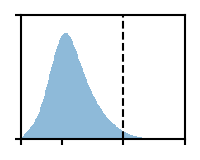

In [31]:
# the cost to histogram
reg_costs = np.copy(idtracker_to_sleap_costs)


# ---- the figure ---- #

fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs

histbins = np.linspace(0, 20, num=200)
ax.hist(reg_costs, label='head', alpha=0.5, density=True, bins=histbins)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

thresh=12.5
ax.axvline(x=thresh, color='black', linestyle='--')

ax.set_xlim(0, 20)
ax.set_ylim(0, 0.2)

ax.set_xticks([0,5,thresh,20])
ax.set_yticks([0, 0.2])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel('')
ax.set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(False)
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_C.png', dpi=300, transparent=True)

# Panel D - fish sizes

In [23]:
# ---- get the size of all fish ---- #


downsample_step = 10

head_pec_sizes = []
pec_tail_sizes = []

for expIdx in np.unique(fight_bout_info_noDurThresh[:,0]):
    print(expIdx)
    exp_nfs = expNumFrames[expIdx]
    traj = raw_trajectories[expIdx]
    
    for fIdx in range(0, exp_nfs, downsample_step):
        for fishIdx in range(2):
            fishData = np.copy(traj[fIdx, fishIdx])
            head_pec_sizes.append(np.linalg.norm(fishData[0]-fishData[1]))
            pec_tail_sizes.append(np.linalg.norm(fishData[1]-fishData[2]))
            
            
head_pec_sizes = np.array(head_pec_sizes)
pec_tail_sizes = np.array(pec_tail_sizes)

0
1
2
3
5
6
7
8
10
11
12
13
14
15
17
18
19
20


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
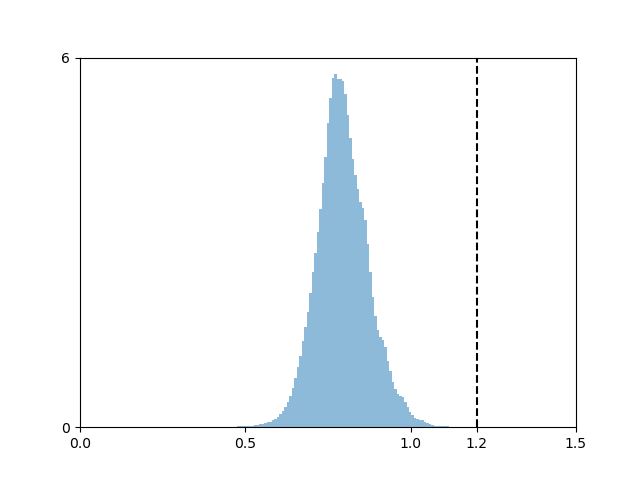

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
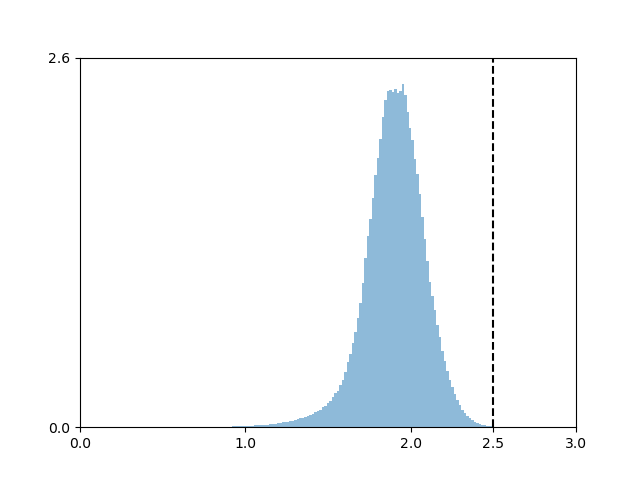

In [24]:
# --- plot the distributions --- #

#(head_pec_sizes[head_pec_sizes!=0]
#pec_tail_sizes[pec_tail_sizes!=0]

fig, axs = plt.subplots()
ax = axs
thresh_val = 1.2
histbins = np.linspace(0, 1.5, num=200)
ax.hist(head_pec_sizes, label='head', alpha=0.5, density=True, bins=histbins);#, log=True);;
ax.set_xlim(0,1.5)
ax.set_xticks([0,0.5,1,thresh_val,1.5])
ax.set_ylim([0,6])
ax.set_yticks([0,6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold



fig, axs = plt.subplots()
ax = axs
thresh_val = 2.5
histbins = np.linspace(0, 3, num=200)
ax.hist(pec_tail_sizes, label='head', alpha=0.5, density=True, bins=histbins);# log=True);;
ax.set_xlim(0,3)
ax.set_xticks([0,1,2,thresh_val,3])
ax.set_ylim([0,2.6])
ax.set_yticks([0,2.6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
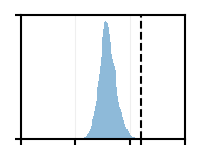

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
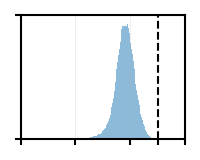

In [25]:

fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs
thresh_val = 1.1
histbins = np.linspace(0, 1.5, num=200)
ax.hist(head_pec_sizes, label='head', alpha=0.5, density=True, bins=histbins);#, log=True);;
ax.set_xlim(0,1.5)
ax.set_xticks([0,0.5,1,thresh_val,1.5])
ax.set_ylim([0,6])
ax.set_yticks([0,6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_B1.png', dpi=300, transparent=True)







fig, axs = plt.subplots(figsize=(2,1.6))
ax = axs
thresh_val = 2.5
histbins = np.linspace(0, 3, num=200)
ax.hist(pec_tail_sizes, label='head', alpha=0.5, density=True, bins=histbins);# log=True);;
ax.set_xlim(0,3)
ax.set_xticks([0,1,2,thresh_val,3])
ax.set_ylim([0,2.6])
ax.set_yticks([0,2.6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_B2.png', dpi=300, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
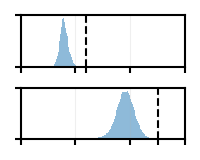

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(2,1.6))



ax = axs[0]
thresh_val = 1.2
histbins = np.linspace(0, 3, num=200)
ax.hist(head_pec_sizes, label='head', alpha=0.5, density=True, bins=histbins);#, log=True);;
ax.set_xlim(0,3)
ax.set_xticks([0,1,thresh_val,2,3])
ax.set_ylim([0,6])
ax.set_yticks([0,6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)




ax = axs[1]
thresh_val = 2.5
histbins = np.linspace(0, 3, num=200)
ax.hist(pec_tail_sizes, label='head', alpha=0.5, density=True, bins=histbins);# log=True);;
ax.set_xlim(0,3)
ax.set_xticks([0,1,2,thresh_val,3])
ax.set_ylim([0,2.6])
ax.set_yticks([0,2.6])
ax.axvline(thresh_val, color='black', linestyle='--') #the threshold

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()



fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fig_tracking_params_D.png', dpi=300, transparent=True)